In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
PATH_TO_DATA = "/mnt/analysis/analysis/DARPA/data/training"

In [13]:
!nvidia-smi

Fri Oct  7 07:01:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:01:00.0  On |                  N/A |
| 41%   54C    P5    46W / 280W |   3098MiB / 24212MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:02:00.0 Off |                  N/A |
| 41%   

In [3]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True, bottleneck=False):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        elif bottleneck:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 4, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels//2, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [4]:
class DoubleUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=False):
        super(DoubleUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        factor = 2 if bilinear else 1
        
        ### MAP ENCODER ###
        self.map_inc = DoubleConv(n_channels, 8)
        self.map_down1 = Down(8, 16)
        self.map_down2 = Down(16, 32)
        self.map_down3 = Down(32, 64)
        self.map_down4 = Down(64, 128 // factor)
        
        ### LABEL ENCODER ###
        self.label_inc = DoubleConv(n_channels, 8)
        self.label_down1 = Down(8, 16)
        self.label_down2 = Down(16, 32)
        self.label_down3 = Down(32, 64)
        self.label_down4 = Down(64, 128 // factor)
        
        self.up1 = Up(256, 64 // factor, bilinear, bottleneck=True)
        self.up2 = Up(64, 32 // factor, bilinear)
        self.up3 = Up(32, 16 // factor, bilinear)
        self.up4 = Up(16, 8, bilinear)
        self.outc = OutConv(8, n_classes)
    
    def map_encoder(self, x):
        x1 = self.map_inc(x)
        x2 = self.map_down1(x1)
        x3 = self.map_down2(x2)
        x4 = self.map_down3(x3)
        x5 = self.map_down4(x4)
        return x1, x2, x3, x4, x5
    
    def label_encoder(self, x):
        x = self.map_inc(x)
        x = self.map_down1(x)
        x = self.map_down2(x)
        x = self.map_down3(x)
        x = self.map_down4(x)
        return x
        
    def forward(self, map_patch, label):
        x1, x2, x3, x4, x5 = self.map_encoder(map_patch)
        label_emb = self.label_encoder(label)
        x_cat = torch.cat((x5, label_emb), axis=1)
        x = self.up1(x_cat, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [5]:
class MapLoader(Dataset):
    def __init__(self, PATH_TO_DATA, label_transform, map_transform, seg_transform):
        self.label_transforms = label_transform
        self.map_transforms = map_transform
        self.seg_transforms = seg_transform
        self.path_to_map = os.path.join(PATH_TO_DATA, "map_patches")
        self.path_to_labels = os.path.join(PATH_TO_DATA, "labels")
        self.path_to_segs = os.path.join(PATH_TO_DATA, "seg_patches")
        self.filenames = os.listdir(self.path_to_map)
        
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        file = self.filenames[idx]
        path_to_map_file = os.path.join(self.path_to_map, file)
        path_to_seg_file = os.path.join(self.path_to_segs, file)
        path_to_label_file = os.path.join(self.path_to_labels, file)
        
        map_patch = self.map_transforms(Image.open(path_to_map_file))
        seg_patch = self.seg_transforms(Image.open(path_to_seg_file))
        label = self.label_transforms(Image.open(path_to_label_file))
        
        ### RESCALE BETWEEN -1 and 1 ###
        map_patch = 2 * map_patch - 1
        label = 2 * label - 1
        
        return map_patch, seg_patch, label
        

In [6]:
# ### CALCULATE NORMALIZATION ###
# data_transform = transforms.Compose([
#     transforms.ToTensor()
# ])

# dataset = MapLoader(PATH_TO_DATA, transforms=data_transform)
# lengths = [int(len(dataset) * 0.95), len(dataset) - int(len(dataset) * 0.95)]
# trainset, _ = random_split(dataset, lengths, generator=torch.Generator().manual_seed(42))

# trainloader = DataLoader(trainset, 
#                          batch_size=32,
#                          shuffle=True,
#                          num_workers=8)

# map_means, map_stds, label_means, label_stds = [], [], [], []

# for i, (map_patch, _, label) in tqdm(enumerate(trainloader), total=len(trainloader)):
#     map_patch = map_patch.numpy()
#     label = label.numpy()
    
#     map_mean = np.mean(map_patch, axis=(0, 2, 3))
#     map_std = np.std(map_patch, axis=(0, 2, 3))
    
#     label_mean = np.mean(label, axis=(0, 2, 3))
#     label_std = np.std(label, axis=(0, 2, 3))
    
#     map_means.append(map_mean)
#     map_stds.append(map_std)
#     label_means.append(label_mean)
#     label_stds.append(label_std)
    

# map_mean = torch.tensor(np.mean(map_means, axis=0))
# map_std = torch.tensor(np.mean(map_stds, axis=0))

# label_mean = torch.tensor(np.mean(label_means, axis=0))
# label_std = torch.tensor(np.mean(label_stds, axis=0))

# print(f"Map Mean: {map_mean}")
# print(f"Map Std: {map_std}")
# print(f"Label Mean: {label_mean}")
# print(f"Label Std: {label_std}")



In [7]:
map_mean = torch.tensor([0.7677, 0.7403, 0.6487])
map_std = torch.tensor([0.2415, 0.2356, 0.2564])
label_mean = torch.tensor([0.8048, 0.7714, 0.6715])
label_std = torch.tensor([0.2528, 0.2472, 0.2757])

map_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(map_mean, map_std)
])

lab_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(map_mean, map_std)
])

seg_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

dataset = MapLoader(PATH_TO_DATA, label_transform=lab_transform, map_transform=map_transform, seg_transform=seg_transform)
lengths = [int(len(dataset) * 0.95), len(dataset) - int(len(dataset) * 0.95)]
trainset, testset = random_split(dataset, lengths, generator=torch.Generator().manual_seed(42))


BATCH_SIZE = 64

trainloader = DataLoader(trainset, 
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=8)


testloader = DataLoader(testset, 
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=8)


In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = DoubleUNet().to(DEVICE)
model = torch.nn.DataParallel(model, device_ids=[0,1])
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
lossfn = nn.BCEWithLogitsLoss()


In [9]:
EPOCHS = 30

smallest_loss = np.inf

mean_train_loss = []
meat_test_loss = []
for epoch in range(1, EPOCHS+1):
    print("****** EPOCH: [{}/{}] LR: {} ******".format(epoch, EPOCHS, round(optimizer.param_groups[0]['lr'], 4)))
    train_loss = []
    test_loss = []

    model.train() # Put in training mode
    loop_train = tqdm(trainloader, total=len(trainloader), leave=True)
    for idx, (map_patch, seg_patch, label) in enumerate(loop_train):
        map_patch, seg_patch, label = map_patch.to(DEVICE), seg_patch.to(DEVICE), label.to(DEVICE)

        optimizer.zero_grad()
        forward_out = model.forward(map_patch, label)

        train_loss_val = lossfn(forward_out, seg_patch)
        train_loss_val.backward()
        optimizer.step()

        train_loss.append(train_loss_val.item())
        
        loop_train.set_description(f"Training")
        loop_train.set_postfix(train_loss=train_loss_val.item())
    
    model.eval()
    loop_test = tqdm(testloader, total=len(testloader), leave=True)
    for idx, (map_patch, seg_patch, label) in enumerate(loop_test):
        map_patch, seg_patch, label = map_patch.to(DEVICE), seg_patch.to(DEVICE), label.to(DEVICE)
    
        with torch.no_grad():
            forward_out = model.forward(map_patch, label) # Forward pass
            test_loss_val = lossfn(forward_out, seg_patch) # Calculate loss

            test_loss.append(test_loss_val.item())
            
            loop_test.set_description(f"Evaluation")
            loop_test.set_postfix(test_loss=test_loss_val.item())
    
    mean_epoch_train_loss = np.mean(train_loss)
    mean_epoch_test_loss = np.mean(test_loss)
    print(f"Training Loss: {mean_epoch_train_loss} Validation Loss: {mean_epoch_test_loss}")
    
    if mean_epoch_test_loss < smallest_loss:
        print(":::SAVING MODEL:::")
        smallest_loss = mean_epoch_test_loss
        torch.save(model.state_dict(), "model_store/map_unet_dual_path_cat_1.pt")
    
    
    
    

****** EPOCH: [1/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 10.90it/s, test_loss=0.201]


Training Loss: 0.3216789688641016 Validation Loss: 0.23000226722609612
:::SAVING MODEL:::
****** EPOCH: [2/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:20<00:00, 10.71it/s, test_loss=0.067]


Training Loss: 0.20942109991980945 Validation Loss: 0.2026928782394405
:::SAVING MODEL:::
****** EPOCH: [3/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:18<00:00, 11.62it/s, test_loss=0.0582]


Training Loss: 0.18213950777657717 Validation Loss: 0.1626211015275821
:::SAVING MODEL:::
****** EPOCH: [4/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:18<00:00, 11.48it/s, test_loss=0.0835]


Training Loss: 0.16111293592237577 Validation Loss: 0.15304447301933843
:::SAVING MODEL:::
****** EPOCH: [5/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 11.41it/s, test_loss=0.0703]


Training Loss: 0.1437189778248624 Validation Loss: 0.1318361650688857
:::SAVING MODEL:::
****** EPOCH: [6/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 11.28it/s, test_loss=0.0742]


Training Loss: 0.13090294922706097 Validation Loss: 0.12431272421427036
:::SAVING MODEL:::
****** EPOCH: [7/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 11.30it/s, test_loss=0.0519]


Training Loss: 0.12268961975927098 Validation Loss: 0.1322244616560123
****** EPOCH: [8/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 11.25it/s, test_loss=0.021] 


Training Loss: 0.11650475881961109 Validation Loss: 0.11306782214460286
:::SAVING MODEL:::
****** EPOCH: [9/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:18<00:00, 11.44it/s, test_loss=0.0205]


Training Loss: 0.11005790985910212 Validation Loss: 0.12571278780973452
****** EPOCH: [10/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:18<00:00, 11.49it/s, test_loss=0.0338]


Training Loss: 0.10539616292993063 Validation Loss: 0.13233893498572336
****** EPOCH: [11/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 11.18it/s, test_loss=0.041] 


Training Loss: 0.10076399779975181 Validation Loss: 0.11235195317644678
:::SAVING MODEL:::
****** EPOCH: [12/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 11.20it/s, test_loss=0.0341]


Training Loss: 0.09786586630209387 Validation Loss: 0.1168627736720896
****** EPOCH: [13/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 11.23it/s, test_loss=0.0394]


Training Loss: 0.09469908603802286 Validation Loss: 0.12128969345430625
****** EPOCH: [14/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 11.08it/s, test_loss=0.65] 


Training Loss: 0.09213334601417844 Validation Loss: 0.17118248690245888
****** EPOCH: [15/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 11.25it/s, test_loss=0.149] 


Training Loss: 0.08897086550448502 Validation Loss: 0.12276335712951449
****** EPOCH: [16/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:18<00:00, 11.44it/s, test_loss=0.0525]


Training Loss: 0.0872648033774805 Validation Loss: 0.121574606008244
****** EPOCH: [17/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:18<00:00, 11.62it/s, test_loss=0.0254]


Training Loss: 0.08497097624009461 Validation Loss: 0.10078146901788525
:::SAVING MODEL:::
****** EPOCH: [18/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 11.38it/s, test_loss=0.0259]


Training Loss: 0.08303149349087485 Validation Loss: 0.10254104165918267
****** EPOCH: [19/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 11.40it/s, test_loss=0.0546]


Training Loss: 0.08141464452248809 Validation Loss: 0.11954197581119251
****** EPOCH: [20/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 11.21it/s, test_loss=0.501]


Training Loss: 0.07888876381287097 Validation Loss: 0.21311894134717055
****** EPOCH: [21/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 11.34it/s, test_loss=0.128] 


Training Loss: 0.07793829708935804 Validation Loss: 0.15538596955861914
****** EPOCH: [22/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 11.25it/s, test_loss=0.347] 


Training Loss: 0.07742668169605488 Validation Loss: 0.19832430237449258
****** EPOCH: [23/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 11.36it/s, test_loss=0.0749]


Training Loss: 0.07564470123933312 Validation Loss: 0.11891179531812668
****** EPOCH: [24/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:20<00:00, 10.52it/s, test_loss=0.226] 


Training Loss: 0.07447822490789602 Validation Loss: 0.1662437147053156
****** EPOCH: [25/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 11.25it/s, test_loss=0.326]


Training Loss: 0.0727098018694914 Validation Loss: 0.17160854114365467
****** EPOCH: [26/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 10.98it/s, test_loss=0.0961]


Training Loss: 0.07168167580057007 Validation Loss: 0.10953418986039228
****** EPOCH: [27/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 11.31it/s, test_loss=1.06] 


Training Loss: 0.07070562272131646 Validation Loss: 0.40088139110446525
****** EPOCH: [28/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:20<00:00, 10.81it/s, test_loss=0.0221]


Training Loss: 0.07017801817428526 Validation Loss: 0.09138643277233921
:::SAVING MODEL:::
****** EPOCH: [29/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 11.31it/s, test_loss=0.0248]


Training Loss: 0.06963058071700004 Validation Loss: 0.07710096736176772
:::SAVING MODEL:::
****** EPOCH: [30/30] LR: 0.0005 ******


Evaluation: 100%|██████████| 217/217 [00:19<00:00, 11.04it/s, test_loss=0.0231]

Training Loss: 0.06801516286569706 Validation Loss: 0.08885961134106882


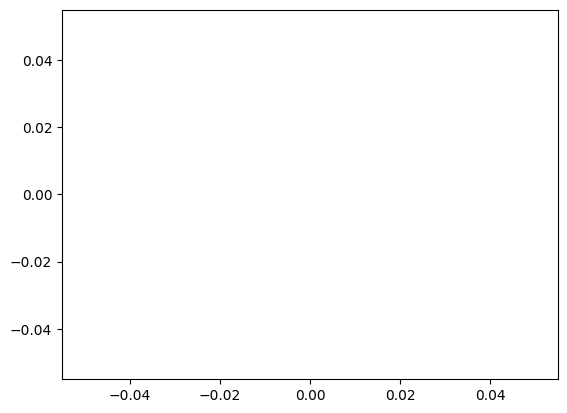